# Model Selection

@roman

Mar 16, 2025

In [217]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import yaml
import joblib
import logging
import warnings

import mlflow
from mlflow.models import infer_signature

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split
import shap
import h3
from catboost import CatBoostRegressor, Pool
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression


In [218]:
# Settings
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# show 100 columns in pandas
pd.set_option('display.max_columns', 500)
TODAY = pd.to_datetime('today')

# dir
DIR_DATA = '../../../data'
DIR_RESULTS = '../../../results'
DIR_MODELS = '../../../models'
FILE_PROPERTIES = f"{DIR_DATA}/clean/properties_shif.parquet"

# must have variables
VARS_MUST_HAVE = [
    'city_cluster', 'state_id', 'municipality_id'
]

In [219]:
# read config
with open("config.yaml", 'r') as stream:
    try:
        config = yaml.safe_load(stream)
        config_model = config['model']
        recaster_mappers = config['categorical_recasters']
        mlflow_config = config['mlflow']

        del config
    except yaml.YAMLError as exc:
        print(exc)

# look
config_model

{'purpose': 'prediction',
 'model_name': 'catboost',
 'hyperparameters': {'iterations': 500,
  'learning_rate': 0.05,
  'loss_function': 'RMSE',
  'eval_metric': 'RMSE',
  'random_seed': 42,
  'verbose': 100,
  'use_best_model': True,
  'early_stopping_rounds': 50},
 'data': {'n_rows': 100000,
  'split_type': 'random',
  'train_size': 0.8,
  'validation_size': 0.1,
  'stratify': 'property_type_id',
  'best_percentage': 0.99},
 'target': {'ppsm_saleable': 'boxcox'},
 'features': {'quarters_since_first_appraisal': 'identity',
  'half_bathrooms': 'identity',
  'full_bathrooms': 'identity',
  'age_in_months': 'identity',
  'parking_lots': 'identity',
  'potable_water_service_id': 'identity',
  'lighting_service_id': 'identity',
  'sidewalk_id': 'identity',
  'conservacion_recat': 'identity',
  'elevator_service_id': 'identity',
  'is_new': 'identity',
  'equipment_id': 'identity',
  'road_materials_id': 'identity',
  'urban_proximity_id': 'identity',
  'electrical_supply_service_id': 'iden

---
# Data

In [220]:
# create function for reading data and returning X and y
def get_target(df, config):
    # read
    target_name = list(config['target'].keys())[0]
    print(target_name)

    # if ppsm2 is in target_name, then we need to calculate the target
    if 'ppsm' in target_name:
        if 'built' in target_name:
            y = df['price'] / df['built_area']
        elif 'saleable' in target_name:
            y = df['price'] / df['saleable_area']
        elif 'land' in target_name:
            y = df['price'] / df['land_area']
        else:
            raise ValueError('Target is not supported')
    elif 'price' in target_name:
        y = df['price']
    else:
        raise ValueError('Target is not supported')
    return y.copy()


def read_data(file, config):
    # read data
    df_work = pd.read_parquet(file)

    # filter data
    n_rows = config.get('data').get('n_rows')
    if n_rows:
        if n_rows < df_work.shape[0]:
            df_work = df_work.sample(n_rows, random_state=42).reset_index(drop=True)

    # set observation_id as index
    df_work = df_work.set_index('observation_id')

    # new features
    first_date_obs = df_work['valuation_date'].min()
    
    df_work = (
        df_work
        .assign(
            # quarters since appraisal
            quarters_since_first_appraisal=lambda x: (x['valuation_date'] - first_date_obs).dt.days / (30.4 * 3),
            # recategorizations
            is_new=lambda x: np.where(x['age_in_months'].le(1), 'new', 'used'),
            conservacion_recat=lambda x: x['conservation_status_id'].replace({7: 3.5}).astype(int),
        )
        .assign(
            is_new=lambda x: x['is_new'].astype('category'),
        )
    )

    # set target
    features_name = list(config['features'].keys())
    X = df_work.loc[:, features_name].copy()
    y = get_target(df_work, config)

    return X, y

In [221]:
# read
X, y = read_data(FILE_PROPERTIES, config_model)

# look
print(f"X shape: {X.shape}")
display(X.head())
print(f"\n y shape: {y.shape}")
display(y.head())

KeyboardInterrupt: 

---
# Feature Engineering

### Transform

In [ ]:
def feature_engineering(X, y, config, recaster_mapper=None):
    # Step 0: Create deep copies to avoid modifying original data
    index = X.index
    transformers = {}  # Dictionary to store all fitted transformers
    
    # Step 1: Check and handle missing values
    missing_values = X.isnull().sum().sum()
    if missing_values > 0:
        logger.warning(f"Warning: {missing_values} missing values detected in the dataset")
        # For production, consider implementing proper missing value handling strategy here
    
    # Step 2: Apply recaster mapping if provided
    if recaster_mapper:
        try:
            X = X.replace(recaster_mapper)
            logger.info("Applied recaster mapping successfully")
        except Exception as e:
            logger.error(f"Error applying recaster mapping: {str(e)}")
            raise ValueError(f"Failed to apply recaster mapping: {str(e)}")
    
    # Step 3: Handle categorical columns
    try:
        cols_categorical = list(set(
            X.select_dtypes(include='string').columns.tolist() +
            X.select_dtypes(include='category').columns.tolist() + 
            X.select_dtypes(include='object').columns.tolist()
        ))
        X[cols_categorical] = X[cols_categorical].astype('category')
        transformers['categorical'] = cols_categorical
        logger.info(f"Processed {len(cols_categorical)} categorical columns")
    except Exception as e:
        logger.error(f"Error processing categorical columns: {str(e)}")
        raise ValueError(f"Failed to process categorical columns: {str(e)}")
    
    # Step 4: Apply feature transformations based on config - BATCH PROCESSING
    valid_transformations = ['identity', 'log', 'sqrt', 'standardize', 'boxcox']
    X_transformed = X.copy()
    
    # Validate all transformations
    for feature, transformation in config['features'].items():
        if transformation not in valid_transformations:
            raise ValueError(f"Unsupported transformation type for feature '{feature}': '{transformation}'. "
                             f"Supported types are: {', '.join(valid_transformations)}")
    
    # Group features by transformation type
    transformation_groups = {trans_type: [] for trans_type in valid_transformations}
    
    for feature, transformation in config['features'].items():
        # Skip features not in dataset
        if feature not in X.columns:
            logger.warning(f"Feature '{feature}' not found in the dataset. Skipping transformation.")
            continue
            
        # Handle features with negative/zero values for log and boxcox
        if transformation in ['log', 'boxcox'] and (X[feature].min() <= 0 or pd.isna(X[feature]).any()):
            logger.warning(f"Feature '{feature}' contains values <= 0 or NaN. "
                           f"Cannot apply {transformation} transformation. Using standardize instead.")
            transformation = 'standardize'

        if transformation == 'sqrt' and (X[feature].min() < 0 or pd.isna(X[feature]).any()):
            logger.warning(f"Feature '{feature}' contains values < 0 or NaN. "
                            f"Cannot apply sqrt transformation. Using standardize instead.")
            transformation = 'standardize'
            
        transformation_groups[transformation].append(feature)
    
    # Process each transformation group
    for transformation, features in transformation_groups.items():
        if not features or transformation == 'identity':
            # Skip empty groups or identity transformation
            logger.info(f"Skipping '{transformation}' transformation for {len(features)} features")
            continue
            
        try:
            logger.info(f"Applying '{transformation}' transformation to {len(features)} features")
            X_transformed[features], transformer = apply_transformation(
                X[features], 
                transformation,
                feature_name=features
            )
            # for i, feature in enumerate(features):
            #     X_transformed[feature] = transformed_data[:, i]
            
            if transformer is not None:
                transformers[transformation] = transformer
                    
        except Exception as e:
            logger.error(f"Error applying {transformation} transformation to features {features}: {str(e)}")
            raise ValueError(f"Failed to apply {transformation} transformation: {str(e)}")
        
    # X_transformed.index = index
    logger.info(f"Applied transformations to features successfully")
    
    # Step 5: Transform target variable if specified
    if 'target' in config:
        target_name = list(config['target'].keys())[0]
        target_transformation = config['target'][target_name]
        
        # Validate target transformation
        if target_transformation not in valid_transformations:
            raise ValueError(f"Unsupported transformation type for target: '{target_transformation}'. "
                             f"Supported types are: {', '.join(valid_transformations)}")
        
        try:
            if (target_transformation in ['log', 'boxcox', 'sqrt'] and 
                (np.min(y) <= 0 or np.isnan(y).any())):
                logger.warning(f"Target contains values <= 0 or NaN. "
                              f"Cannot apply {target_transformation} transformation. Using standardize instead.")
                target_transformation = 'standardize'
                
            y_transformed, target_transformer = apply_transformation(
                y.to_frame(),
                target_transformation,
                feature_name=target_name
            )
            y_transformed = pd.Series(y_transformed.flatten(), index=y.index)
            
            if target_transformer is not None:
                transformers["target"] = target_transformer
                
            logger.info(f"Applied '{target_transformation}' transformation to target variable")
            
        except Exception as e:
            logger.error(f"Error transforming target variable: {str(e)}")
            raise ValueError(f"Failed to transform target variable: {str(e)}")
    else:
        logger.warning("No target transformation specified in config")
    
    return X_transformed, y_transformed, transformers


def apply_transformation(data, transformation_type, feature_name=None):
    name_info = f" for '{feature_name}'" if feature_name else ""
        
    if transformation_type == 'identity':
        return data, None
    
    elif transformation_type == 'log':
        # apply log transformation
        transformed_data = np.log(data)
        # standardize
        transformer = StandardScaler()
        transformed_data = transformer.fit_transform(transformed_data)

        return transformed_data, transformer
    
    elif transformation_type == 'sqrt':
        # apply sqrt transformation
        transformed_data = np.sqrt(data)
        # standardize
        transformer = StandardScaler()
        transformed_data = transformer.fit_transform(transformed_data)
        return transformed_data, transformer
        
    elif transformation_type == 'standardize':
        transformer = StandardScaler()
        transformed_data = transformer.fit_transform(data)
        return transformed_data, transformer
        
    elif transformation_type == 'boxcox':
        transformer = PowerTransformer(method='box-cox', standardize=True)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            transformed_data = transformer.fit_transform(data)
        return transformed_data, transformer
        
    else:
        raise ValueError(f"Unsupported transformation type{name_info}: '{transformation_type}'")


def save_transformers(transformers, filepath):
    try:
        joblib.dump(transformers, filepath)
        logger.info(f"Saved transformers to {filepath}")
        return True
    except Exception as e:
        logger.error(f"Error saving transformers: {str(e)}")
        return False


def load_transformers(filepath):
    try:
        transformers = joblib.load(filepath)
        logger.info(f"Loaded transformers from {filepath}")
        return transformers
    except Exception as e:
        logger.error(f"Error loading transformers: {str(e)}")
        raise ValueError(f"Failed to load transformers: {str(e)}")


def transform_features(X, transformers):
    X_transformed = X.copy()
    
    # Apply categorical transformations
    if 'categorical' in transformers:
        cols_categorical = transformers['categorical']
        present_cols = [col for col in cols_categorical if col in X.columns]
        X[present_cols] = X[present_cols].astype('category')

    for transformation_type, features in transformers.items():
        if transformation_type == 'categorical' and len(features) > 0:
            cols_categorical = transformers['categorical']
            present_cols = [col for col in cols_categorical if col in X.columns]
            X[present_cols] = X[present_cols].astype('category')

        elif transformation_type == 'log' and len(features) > 0:
            # apply log transformation
            X_transformed[features] = np.log(X[features])
            # standardize with fitted transformer
            transformer = transformers['log']
            X_transformed[features] = transformer.transform(X_transformed[features])
        
        elif transformation_type == 'sqrt' and len(features) > 0:
            # apply sqrt transformation
            X_transformed[features] = np.sqrt(X[features])
            # standardize with fitted transformer
            transformer = transformers['sqrt']
            X_transformed[features] = transformer.transform(X_transformed[features])

        elif transformation_type == 'standardize' and len(features) > 0:
            # standardize with fitted transformer
            transformer = transformers['standardize']
            X_transformed[features] = transformer.transform(X[features])

        elif transformation_type == 'boxcox' and len(features) > 0:
            # apply boxcox transformation
            transformer = transformers['boxcox']
            X_transformed[features] = transformer.transform(X[features])

    return X_transformed


def inverse_transform_target(y_pred, transformers):
    if "target" not in transformers or transformers["target"] is None:
        return y_pred
    
    try:
        # Reshape if needed
        y_pred_reshaped = y_pred.reshape(-1, 1) if len(y_pred.shape) == 1 else y_pred
            
        inverse_transformed = transformers["target"].inverse_transform(y_pred_reshaped)
        
        # Flatten if single column
        if inverse_transformed.shape[1] == 1:
            inverse_transformed = inverse_transformed.flatten()
            
        return inverse_transformed
    except Exception as e:
        logger.error(f"Error inverse transforming target: {str(e)}")
        raise ValueError(f"Failed to inverse transform target: {str(e)}")


class FeatureTransformer:   
    def __init__(self, config, recaster_mapper=None):
        self.config = config
        self.recaster_mapper = recaster_mapper
        self.transformers_ = None
        
    def fit(self, X, y=None):
        """Fit the transformer on the training data."""
        _, _, self.transformers_ = feature_engineering(X, y, self.config, self.recaster_mapper)
        return self
        
    def transform(self, X):
        """Transform the features."""
        return transform_features(X, self.transformers_)
        
    def fit_transform(self, X, y=None):
        """Fit the transformer and transform the features."""
        X_transformed, y_transformed, self.transformers_ = feature_engineering(X, y, self.config, self.recaster_mapper)
        return X_transformed, y_transformed
        
    def get_transformers(self):
        """Get the fitted transformers."""
        return self.transformers_
    
    def save_transformers(self, filepath):
        """Save the fitted transformers to a file."""
        return save_transformers(self.transformers_, filepath)
    
    def load_transformers(self, filepath):
        """Load transformers from a file."""
        self.transformers_ = load_transformers(filepath)
        return self
    
    def inverse_transform_target(self, y_pred):
        """Inverse transform the target variable."""
        return inverse_transform_target(y_pred, self.transformers_)

In [ ]:
# feature transformer
transformer = FeatureTransformer(config_model, recaster_mappers)
X_trans, y_trans = transformer.fit_transform(X, y)

2025-03-17 12:50:46,531 - INFO - Applied recaster mapping successfully
2025-03-17 12:50:46,618 - INFO - Processed 12 categorical columns
2025-03-17 12:50:46,623 - WARNING - Feature 'land_area' contains values <= 0 or NaN. Cannot apply log transformation. Using standardize instead.
2025-03-17 12:50:46,626 - INFO - Skipping 'identity' transformation for 48 features
2025-03-17 12:50:46,626 - INFO - Applying 'log' transformation to 2 features
2025-03-17 12:50:46,637 - INFO - Applying 'sqrt' transformation to 5 features
2025-03-17 12:50:46,664 - INFO - Applying 'standardize' transformation to 1 features
2025-03-17 12:50:46,667 - INFO - Applying 'boxcox' transformation to 1 features
2025-03-17 12:50:46,825 - INFO - Applied transformations to features successfully
2025-03-17 12:50:46,996 - INFO - Applied 'boxcox' transformation to target variable


### Compare

In [ ]:

# look
print(f"{'='*10} X {'='*10}")
display(X_trans.describe().T)

print(f"\n{'='*10} y {'='*10}")
display(y_trans.describe())

/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow

========== X ==========


/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


,count,mean,std,min,25%,50%,75%,max
quarters_since_first_appraisal,100000.0,9.933665e+00,5.877024,0.000000,4.835526,9.605263,15.252193,19.989035
half_bathrooms,100000.0,3.483100e-01,0.513160,0.000000,0.000000,0.000000,1.000000,6.000000
full_bathrooms,100000.0,1.489060e+00,0.807271,1.000000,1.000000,1.000000,2.000000,8.000000
age_in_months,100000.0,5.275068e+01,73.143562,0.000000,0.000000,8.000000,96.000000,255.000000
parking_lots,100000.0,1.136580e+00,0.660235,0.000000,1.000000,1.000000,1.000000,8.000000
conservacion_recat,100000.0,4.977870e+00,1.007328,3.000000,4.000000,5.000000,6.000000,6.000000
level,100000.0,3.446660e+00,1.772824,0.000000,3.000000,3.000000,3.000000,33.000000
total_levels,100000.0,1.596730e+00,1.100498,0.000000,1.000000,1.000000,2.000000,42.000000
bedrooms,100000.0,2.356260e+00,0.685437,1.000000,2.000000,2.000000,3.000000,6.000000
built_area,100000.0,-5.898393e-16,1.000005,-1.888610,-0.793725,-0.240885,0.621407,5.892379



========== y ==========


count    1.000000e+05
mean    -2.540118e-13
std      1.000005e+00
min     -4.524018e+00
25%     -6.188285e-01
50%     -4.193055e-02
75%      6.111298e-01
max      2.987144e+00
dtype: float64

In [ ]:
# look obs
mask = X.sample(5).index

# original
display(X.loc[mask, :])
display(y.loc[mask])

# transformed
display(X_trans.loc[mask, :])
display(y_trans.loc[mask])

,quarters_since_first_appraisal,half_bathrooms,full_bathrooms,age_in_months,parking_lots,potable_water_service_id,lighting_service_id,sidewalk_id,conservacion_recat,elevator_service_id,is_new,equipment_id,road_materials_id,urban_proximity_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,level,total_levels,bedrooms,built_area,saleable_area,land_area,remaining_useful_life,distance_to_ocean,ocean_label,count_supermarkets_at_1km,count_hospitals_at_5km,count_metro_at_1km,count_schools_at_1km,count_restaurants_at_1km,est_socio,educa_jefe,tot_integ,p12_64,p65mas,percep_ing,ing_cor,estim_alqu,otros_ing,gasto_mon,vivienda,alquiler,pred_cons,cuidados,antiguedad,cuart_dorm,tenencia,renta,estim_pago,pago_viv,pago_mesp,tipo_adqui,viv_usada,tipo_finan,total_viviendas,ppsm_terrain
observation_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8c8b6115-05b6-43e9-a205-73235536c60a,14.671053,0,1,108,1,1,2,1,4,1,used,4,2,2,1,1,4,7,1,2,50,50,15,61,100000,no_ocean,5,27,0,0,0,3.035156,7.476562,2.970703,2.259766,0.360107,2.287109,77679.039062,15234.750000,0.000000,52198.500000,5287.248047,2527.297607,675.435547,1975.968384,24.921875,2.109375,4,858.885376,5196.161621,420.919495,0.250373,1.0,0.186035,5,151997,18914
b240ddfb-a433-44c9-ba28-fcbe1ff7e613,18.168860,0,1,84,1,1,3,1,5,2,used,3,2,3,2,1,3,3,1,2,43,43,90,53,100000,no_ocean,0,0,0,0,0,2.650391,6.480469,3.396484,2.568359,0.235107,2.228516,86082.132812,9908.669922,81.251686,43984.742188,5277.778320,1590.093140,404.781219,1791.451538,19.328125,2.060547,4,529.978882,3375.678711,648.404541,0.353761,1.0,0.195923,1,475618,1735
bff75417-5b2e-473c-bf85-466fc545bbea,7.697368,0,1,0,1,0,0,0,6,2,new,3,3,4,0,0,2,3,1,2,61,62,197,60,50000,golfo_de_mexico,0,0,0,0,0,2.720703,6.550781,3.318359,2.425781,0.355957,2.326172,63967.066406,8231.510742,64.610939,36368.339844,3117.251465,1027.252319,220.513535,2289.642334,21.890625,1.977539,4,356.776154,2803.710205,513.943909,0.267777,1.0,0.181885,5,305336,1244
1f0a245d-f71f-427e-acf2-9843ce341a72,5.701754,1,1,0,1,0,0,0,6,2,new,3,2,2,0,0,2,3,2,2,76,80,126,70,10000,golfo_de_california,2,2,0,0,0,2.478516,6.101562,3.414062,2.484375,0.395264,2.265625,57579.773438,6702.343750,0.000000,28112.582031,4243.464355,943.445007,215.882828,1175.880249,23.468750,1.990234,4,305.564697,2264.696533,165.439194,0.145619,1.0,0.191162,5,57218,1295
febd46b9-d161-4119-a86e-49ae048d08db,17.258772,0,1,20,1,1,2,1,4,2,used,3,2,2,1,1,2,3,1,2,57,57,86,37,100000,no_ocean,2,2,0,0,2,2.923828,7.117188,3.130859,2.351562,0.298584,2.283203,90356.000000,11170.201172,147.780579,51204.972656,6005.731934,1422.439209,245.990616,2326.163330,20.234375,2.041016,4,499.485260,3803.725098,924.110413,0.339089,1.0,0.239258,1,271693,1585


observation_id
8c8b6115-05b6-43e9-a205-73235536c60a    26400.000000
b240ddfb-a433-44c9-ba28-fcbe1ff7e613    13581.395349
bff75417-5b2e-473c-bf85-466fc545bbea    11612.903226
1f0a245d-f71f-427e-acf2-9843ce341a72    11287.500000
febd46b9-d161-4119-a86e-49ae048d08db    15929.824561
dtype: float64

,quarters_since_first_appraisal,half_bathrooms,full_bathrooms,age_in_months,parking_lots,potable_water_service_id,lighting_service_id,sidewalk_id,conservacion_recat,elevator_service_id,is_new,equipment_id,road_materials_id,urban_proximity_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,level,total_levels,bedrooms,built_area,saleable_area,land_area,remaining_useful_life,distance_to_ocean,ocean_label,count_supermarkets_at_1km,count_hospitals_at_5km,count_metro_at_1km,count_schools_at_1km,count_restaurants_at_1km,est_socio,educa_jefe,tot_integ,p12_64,p65mas,percep_ing,ing_cor,estim_alqu,otros_ing,gasto_mon,vivienda,alquiler,pred_cons,cuidados,antiguedad,cuart_dorm,tenencia,renta,estim_pago,pago_viv,pago_mesp,tipo_adqui,viv_usada,tipo_finan,total_viviendas,ppsm_terrain
observation_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8c8b6115-05b6-43e9-a205-73235536c60a,14.671053,0,1,108,1,exists,b,concrete,4,exists,used,perfect,asphalt,intermediate,with_suminister,aerial,apartment,7,1,2,-0.754199,-0.777490,-0.868015,61,100000,no_ocean,2.468750,3.591797,-0.143677,-0.224976,-0.373535,3.035156,7.476562,2.970703,2.259766,0.360107,2.287109,77679.039062,15234.750000,0.000000,52198.500000,5287.248047,2527.297607,675.435547,1975.968384,24.921875,2.109375,4,858.885376,5196.161621,420.919495,0.250373,1.0,0.186035,5,151997,1.920034
b240ddfb-a433-44c9-ba28-fcbe1ff7e613,18.168860,0,1,84,1,exists,c,concrete,5,not_exist,used,high,asphalt,peripheral,without_suminister,aerial,house_on_condominium,3,1,2,-1.049283,-1.053946,-0.194199,53,100000,no_ocean,-0.810547,-0.832031,-0.143677,-0.224976,-0.373535,2.650391,6.480469,3.396484,2.568359,0.235107,2.228516,86082.132812,9908.669922,81.251686,43984.742188,5277.778320,1590.093140,404.781219,1791.451538,19.328125,2.060547,4,529.978882,3375.678711,648.404541,0.353761,1.0,0.195923,1,475618,-0.854857
bff75417-5b2e-473c-bf85-466fc545bbea,7.697368,0,1,0,1,does_not_apply,does_not_apply,does_not_apply,6,not_exist,new,high,concrete,expansion,does_not_apply,does_not_apply,house,3,1,2,-0.365148,-0.383193,0.767111,60,50000,golfo_de_mexico,-0.810547,-0.832031,-0.143677,-0.224976,-0.373535,2.720703,6.550781,3.318359,2.425781,0.355957,2.326172,63967.066406,8231.510742,64.610939,36368.339844,3117.251465,1027.252319,220.513535,2289.642334,21.890625,1.977539,4,356.776154,2803.710205,513.943909,0.267777,1.0,0.181885,5,305336,-1.585834
1f0a245d-f71f-427e-acf2-9843ce341a72,5.701754,1,1,0,1,does_not_apply,does_not_apply,does_not_apply,6,not_exist,new,high,asphalt,intermediate,does_not_apply,does_not_apply,house,3,2,2,0.065005,0.084022,0.129232,70,10000,golfo_de_california,1.262695,0.371582,-0.143677,-0.224976,-0.373535,2.478516,6.101562,3.414062,2.484375,0.395264,2.265625,57579.773438,6702.343750,0.000000,28112.582031,4243.464355,943.445007,215.882828,1175.880249,23.468750,1.990234,4,305.564697,2264.696533,165.439194,0.145619,1.0,0.191162,5,57218,-1.490787
febd46b9-d161-4119-a86e-49ae048d08db,17.258772,0,1,20,1,exists,b,concrete,4,not_exist,used,high,asphalt,intermediate,with_suminister,aerial,house,3,1,2,-0.497843,-0.537316,-0.230136,37,100000,no_ocean,1.262695,0.371582,-0.143677,-0.224976,0.811035,2.923828,7.117188,3.130859,2.351562,0.298584,2.283203,90356.000000,11170.201172,147.780579,51204.972656,6005.731934,1422.439209,245.990616,2326.163330,20.234375,2.041016,4,499.485260,3803.725098,924.110413,0.339089,1.0,0.239258,1,271693,-1.041362


observation_id
8c8b6115-05b6-43e9-a205-73235536c60a    1.501473
b240ddfb-a433-44c9-ba28-fcbe1ff7e613    0.240308
bff75417-5b2e-473c-bf85-466fc545bbea   -0.158624
1f0a245d-f71f-427e-acf2-9843ce341a72   -0.236126
febd46b9-d161-4119-a86e-49ae048d08db    0.601760
dtype: float64

In [ ]:
# look transformers
transformer.get_transformers()

{'categorical': ['potable_water_service_id',
  'elevator_service_id',
  'ocean_label',
  'road_materials_id',
  'sidewalk_id',
  'urban_proximity_id',
  'lighting_service_id',
  'equipment_id',
  'property_type_id',
  'is_new',
  'telephone_service_supply_id',
  'electrical_supply_service_id'],
 'log': StandardScaler(),
 'sqrt': StandardScaler(),
 'standardize': StandardScaler(),
 'boxcox': PowerTransformer(method='box-cox'),
 'target': PowerTransformer(method='box-cox')}

In [ ]:
# look for log transformers
transformer.get_transformers()['boxcox'].feature_names_in_

array(['ppsm_terrain'], dtype=object)

In [ ]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


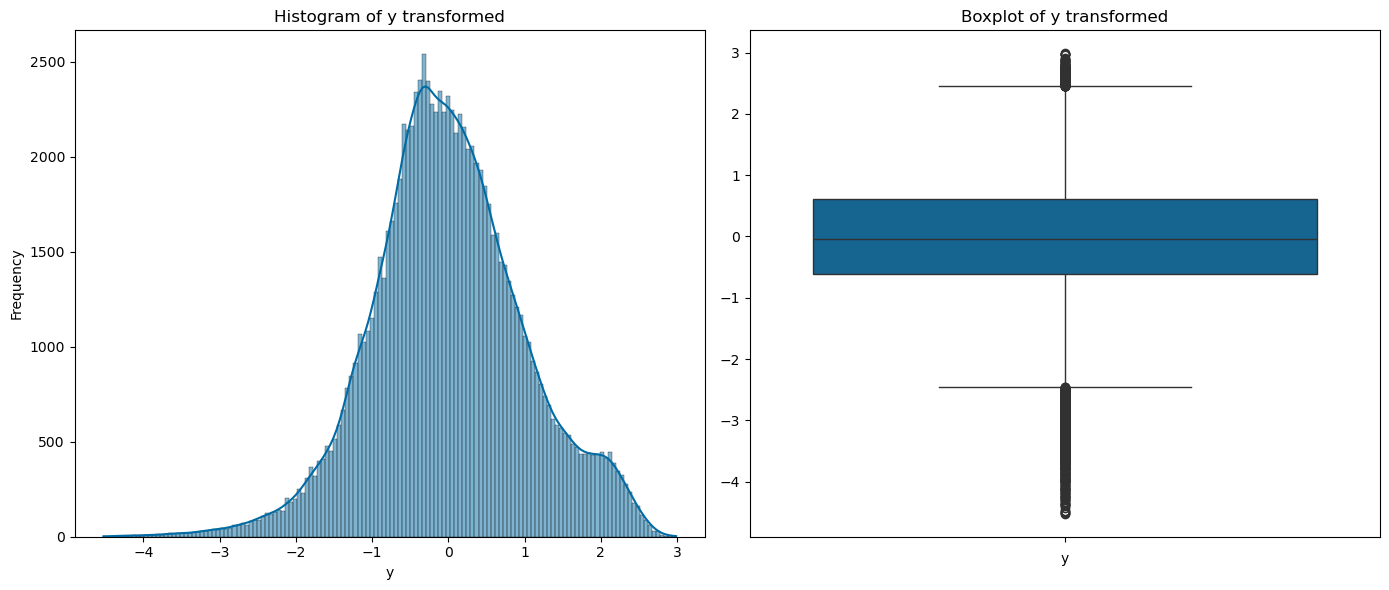

In [ ]:
# plot y transformed
def plot_y(y):
    with plt.style.context(style='tableau-colorblind10'):
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))
        sns.histplot(y, kde=True, ax=ax[0])
        ax[0].set_title('Histogram of y transformed')
        ax[0].set_xlabel('y')
        ax[0].set_ylabel('Frequency')

        sns.boxplot(y, ax=ax[1])
        ax[1].set_title('Boxplot of y transformed')
        ax[1].set_xlabel('y')

        plt.tight_layout()
    plt.close(fig)
    return fig

# plot
plot_y(y_trans)
    

---
# Split

In [ ]:
# function to split data
def split_randomly_data(X, y, config, categorical_features=None):
    """
    The config is a dictionary that contains train_size (in percentage), the startification variable (if not null) and validation_size (if applicable)
    """
    # split train & test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        train_size=config['train_size'],
        random_state=42,
        stratify=X[config['stratify']] if config['stratify'] else None
    )

    # Split validation set if specified
    val_percentage_raw = config.get('validation_size')
    if val_percentage_raw:
        if val_percentage_raw > 0:
            X_train, X_val, y_train, y_val = train_test_split(
                X_train, y_train,
                test_size=val_percentage_raw,
                random_state=42,
                stratify=X_train[config['stratify']] if config['stratify'] else None
            )
    else:
        X_val, y_val = None, None

    return {
        'train': Pool(X_train, y_train, cat_features=categorical_features),
        'validation': Pool(X_val, y_val, cat_features=categorical_features) if X_val is not None else None,
        'test': Pool(X_test, y_test, cat_features=categorical_features)
    }

# split data
dict_data = split_randomly_data(X_trans, y_trans, config_model['data'], transformer.get_transformers()['categorical'])

In [ ]:
# size of each dataset
dict_shapes = {}
for key, value in dict_data.items():
    if value is not None:
        dict_shapes[f'n_{key}'] = value.num_row()
        print(f"{key}: N: {value.num_row()}. Percent {value.num_row() / X_trans.shape[0]:.2%}")

# print dict
dict_shapes

train: N: 72000. Percent 72.00%
validation: N: 8000. Percent 8.00%
test: N: 20000. Percent 20.00%


{'n_train': 72000, 'n_validation': 8000, 'n_test': 20000}

---
# Train

In [ ]:
# init catboost
model = CatBoostRegressor(**config_model['hyperparameters'])

# fit model
model.fit(
    X=dict_data['train'],
    eval_set=dict_data['validation'] if dict_data['validation'] is not None else None,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9691127	test: 0.9737769	best: 0.9737769 (0)	total: 57.1ms	remaining: 28.5s
100:	learn: 0.4329768	test: 0.4414496	best: 0.4414496 (100)	total: 3.48s	remaining: 13.7s
200:	learn: 0.3898043	test: 0.3990444	best: 0.3990444 (200)	total: 6.96s	remaining: 10.4s
300:	learn: 0.3699171	test: 0.3808249	best: 0.3808249 (300)	total: 10.4s	remaining: 6.88s
400:	learn: 0.3575498	test: 0.3700030	best: 0.3700030 (400)	total: 13.9s	remaining: 3.43s
499:	learn: 0.3493324	test: 0.3630586	best: 0.3630586 (499)	total: 17.4s	remaining: 0us

bestTest = 0.3630586133
bestIteration = 499



In [ ]:
# get feature importance
df_feature_importance = pd.DataFrame({
    'feature': model.feature_names_,
    'importance': model.feature_importances_
})

df_feature_importance.sort_values('importance', ascending=False, ignore_index=True)

,feature,importance
0,ppsm_terrain,30.002385
1,quarters_since_first_appraisal,14.523656
2,remaining_useful_life,10.150874
3,saleable_area,9.441717
4,land_area,4.852234
5,conservacion_recat,3.921930
6,property_type_id,2.732910
7,elevator_service_id,2.662812
8,age_in_months,1.961378
9,parking_lots,1.678060


In [ ]:
# predict train
def get_target_value(y, transformer):
    return transformer.inverse_transform_target(y)

def get_predictions(model, data, transformer):
    return get_target_value(model.predict(data), transformer)


---
# Test

## Metrics

In [ ]:
def calculate_metrics(y, y_pred, best_percent=1.0):
    # Create a DataFrame to hold y, y_pred, and MAPE
    df = pd.DataFrame({
        'y': y,
        'y_pred': y_pred
    })
    
    # Calculate APE
    df['perc_error'] = 1 - df['y_pred'] / df['y']
    df['ape'] = np.abs(df['perc_error'])
    
    # Determine the threshold ape to filter the best_percent data
    threshold_ape = df['ape'].quantile(best_percent)
    
    # Filter the best_percent of the data
    df_best = df[df['ape'] <= threshold_ape]
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(df_best['y'], df_best['y_pred']))
    mape = df_best['ape'].mean()
    meape = df_best['ape'].median()
    r2 = r2_score(df_best['y'], df_best['y_pred'])
    n_size = int(len(y))
    worst_negative_error = df['perc_error'].min()
    worst_positive_error = df['perc_error'].max()
    
    return pd.Series({
        "mape": mape,
        "meape": meape,
        "rmse": rmse,
        "r2": r2,
        "n_size": n_size,
        "worst_negative_error": worst_negative_error,
        "worst_positive_error": worst_positive_error
    })

In [ ]:
# get stats for each dataset and save it in a dataframe
tbl_results = pd.DataFrame({
    k: calculate_metrics(
        y=get_target_value(v.get_label(), transformer),
        y_pred=get_predictions(model, v, transformer),
        best_percent=config_model['data'].get('best_percentage')
    )
    for k, v in dict_data.items()
}).T

tbl_results

,mape,meape,rmse,r2,n_size,worst_negative_error,worst_positive_error
train,0.098003,0.078052,2734.370739,0.912654,72000.0,-1.623571,0.718549
validation,0.100267,0.077781,2844.313575,0.903766,8000.0,-1.073502,0.568017
test,0.099570,0.078453,2773.954705,0.908079,20000.0,-1.350010,0.605059


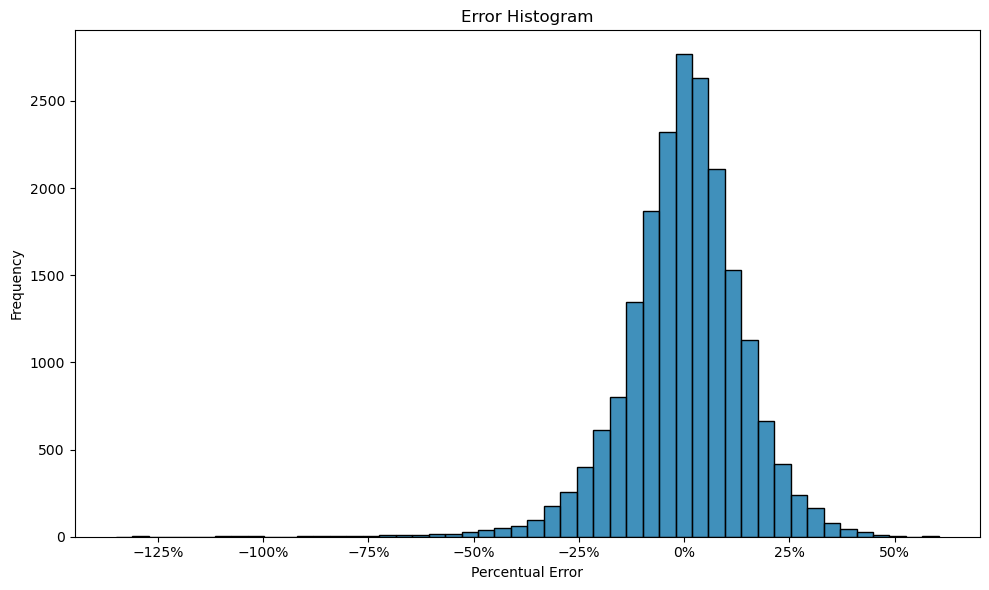

In [ ]:
# get histogram of error
def plot_error_histogram(y, y_pred):
    # create error
    error = 1 - y_pred / y

    # plot
    with plt.style.context(style='tableau-colorblind10'):
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.histplot(
            error,
            kde=False,
            bins=50,
            label='Percentual Error'
        )

        # labels
        plt.xlabel('Percentual Error')
        plt.ylabel('Frequency')
        plt.title('Error Histogram')

        # x ticks in percentage
        plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
        plt.tight_layout()

    # save
    plt.close(fig)
    return fig

# plot error histogram for test
plot_error_histogram(
    y=get_target_value(dict_data['test'].get_label(), transformer),
    y_pred=get_predictions(model, dict_data['test'], transformer)
)


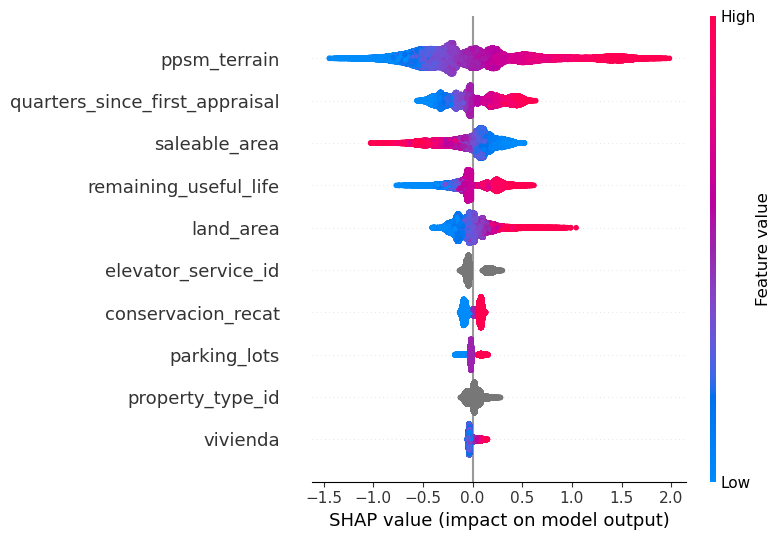

In [ ]:
# get feature importance
def plot_feature_importance(model, X, n_size):
    explainer = shap.TreeExplainer(model)

    # shap values
    shap_values = explainer.shap_values(X)

    # plot
    with plt.style.context(style='tableau-colorblind10'):
        fig, ax = plt.subplots(figsize=(12, 8))
        shap.summary_plot(
            shap_values,
            X,
            max_display=n_size,
            show=False
        )
        plt.tight_layout()
    plt.close(fig)
    return fig

# plot feature importance
plot_feature_importance(model, X_trans, 10)

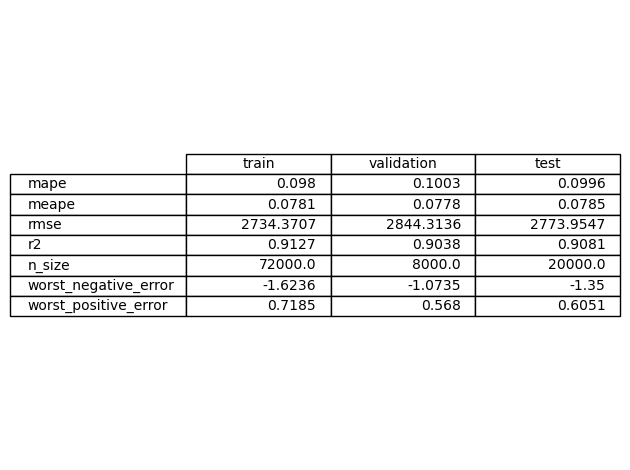

In [ ]:
# get an image of the tbl_results
def plot_results_table(tbl_results):
    # roand to decimals
    tbl_results = tbl_results.round(4).T

    # plot
    with plt.style.context(style='tableau-colorblind10'):
        fig, ax = plt.subplots()

        # remove axis
        ax.axis('off')
        ax.axis('tight')
        
        # plot table
        ax.table(
            cellText=tbl_results.values,
            colLabels=tbl_results.columns,
            rowLabels=tbl_results.index,
            loc='center'
        )
        plt.tight_layout()
    plt.close(fig)
    return fig    

    
# plot results table
plot_results_table(tbl_results)

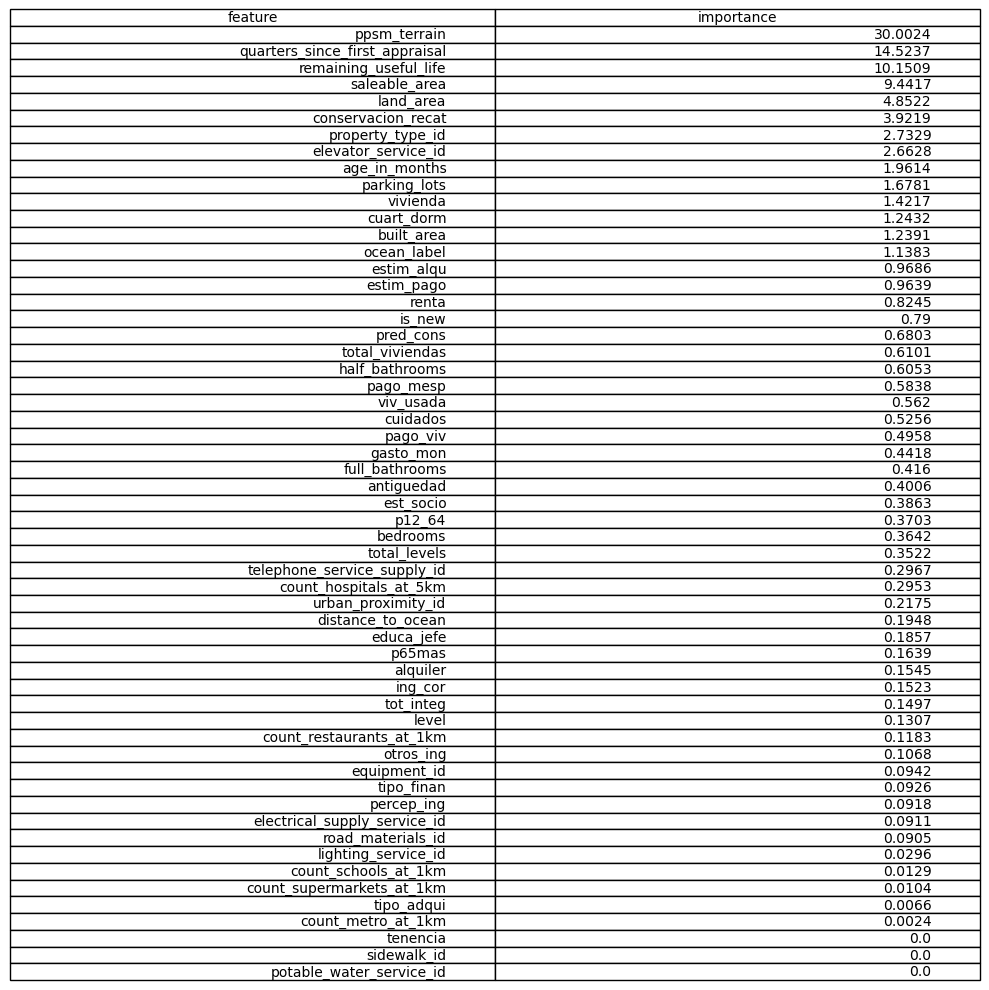

In [225]:
# get an image of the feature importance
def plot_feature_importance_in_table(model):
    # get feature importance
    df_feature_importance = pd.DataFrame({
        'feature': model.feature_names_,
        'importance': model.feature_importances_
    }).round(4)

    df_feature_importance = df_feature_importance.sort_values('importance', ascending=False, ignore_index=True)

    # plot
    with plt.style.context(style='tableau-colorblind10'):
        fig, ax = plt.subplots(figsize=(10, 10))

        # remove axis
        ax.axis('off')
        ax.axis('tight')

        # plot table
        ax.table(
            cellText=df_feature_importance.values,
            colLabels=df_feature_importance.columns,
            loc='center'
        )
        plt.tight_layout()
    plt.close(fig)
    return fig

# plot feature importance
plot_feature_importance_in_table(model)

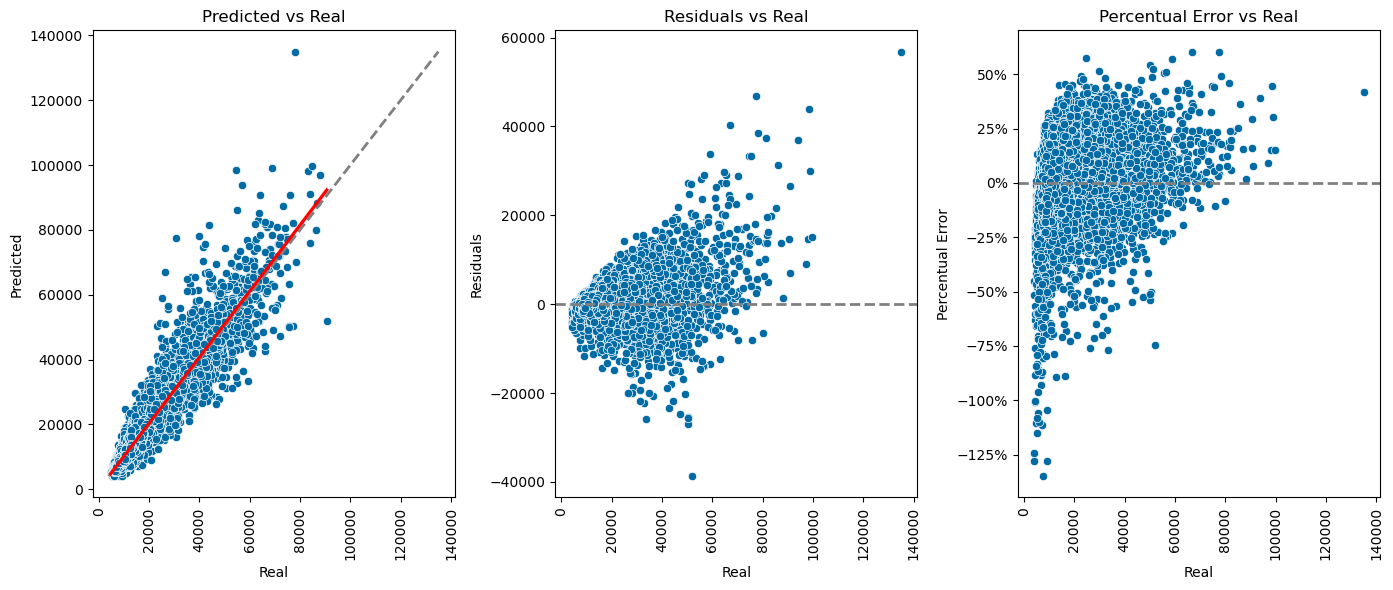

In [ ]:
# plot predicted vs real
def plot_predicted_vs_real(y, y_pred):
    # residuals
    residuals = y - y_pred

    # plot
    with plt.style.context(style='tableau-colorblind10'):
        # y pred vs y
        fig, ax = plt.subplots(1, 3, figsize=(14, 6))
        sns.scatterplot(y=y, x=y_pred, ax=ax[0])
        ax[0].set_title('Predicted vs Real')
        ax[0].set_xlabel('Real')
        ax[0].set_ylabel('Predicted')
        # add identity
        ax[0].plot([y.min(), y.max()], [y.min(), y.max()], color='gray', lw=2, linestyle='--')
        # add regression line
        sns.regplot(y=y, x=y_pred, ax=ax[0], scatter=False, color='red')
        # x ticks 90 degrees
        ax[0].tick_params(axis='x', rotation=90)

        # residuals
        sns.scatterplot(x=y, y=residuals, ax=ax[1])
        ax[1].set_title('Residuals vs Real')
        ax[1].set_xlabel('Real')
        ax[1].set_ylabel('Residuals')
        # add zero line
        ax[1].axhline(0, color='gray', lw=2, linestyle='--')
        # x ticks 90 degrees
        ax[1].tick_params(axis='x', rotation=90)

        # percentual error
        sns.scatterplot(x=y, y=residuals / y, ax=ax[2])
        ax[2].set_title('Percentual Error vs Real')
        ax[2].set_xlabel('Real')
        ax[2].set_ylabel('Percentual Error')
        # add zero line
        ax[2].axhline(0, color='gray', lw=2, linestyle='--')
        # y label in percentage
        ax[2].yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
        # x ticks 90 degrees
        ax[2].tick_params(axis='x', rotation=90)

        plt.tight_layout()
    plt.close(fig)
    return fig

# plot
plot_predicted_vs_real(
    y=get_target_value(dict_data['test'].get_label(), transformer),
    y_pred=get_predictions(model, dict_data['test'], transformer)
)

---
# Save model in MLFlow

## Tracking

In [ ]:
# set traking url
mlflow_uri = f"http://{mlflow_config['host']}:{mlflow_config['port']}"

# set tracking
mlflow.set_tracking_uri(mlflow_uri)

In [ ]:
# set experiment
experiment_name = mlflow_config['experiment_name']

# set experiment
mlflow.set_experiment(experiment_name)

2025/03/17 17:11:41 INFO mlflow.tracking.fluent: Experiment with name 'housing_valuation' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/301326788672273783', creation_time=1742253101856, experiment_id='301326788672273783', last_update_time=1742253101856, lifecycle_stage='active', name='housing_valuation', tags={}>

In [ ]:
# Create dictionaries
# s1: parameters
dict_params = {
    f"hyperparameters__{k}": v
    for k, v in config_model['hyperparameters'].items()
}

dict_params.update({
    f"data__{k}": v
    for k, v in config_model['data'].items()
    if k not in ['split_type']
})

dict_params

{'hyperparameters__iterations': 500,
 'hyperparameters__learning_rate': 0.05,
 'hyperparameters__loss_function': 'RMSE',
 'hyperparameters__eval_metric': 'RMSE',
 'hyperparameters__random_seed': 42,
 'hyperparameters__verbose': 100,
 'hyperparameters__use_best_model': True,
 'hyperparameters__early_stopping_rounds': 50,
 'data__n_rows': 100000,
 'data__split_type': 'random',
 'data__train_size': 0.8,
 'data__validation_size': 0.1,
 'data__h3_resolution': 8,
 'data__stratify': 'property_type_id',
 'data__best_percentage': 0.99}

In [ ]:
# s2: create metrics
dict_metrics = {
    f"test__{k}": v
    for k, v in tbl_results.query('index == "test"').to_dict(orient='records')[0].items()
    if k not in ['worst_negative_error', 'worst_positive_error', 'r2', 'n_size']
}
dict_metrics.update({
    f"train__{k}": v
    for k, v in tbl_results.query('index == "train"').to_dict(orient='records')[0].items()
    if k not in ['worst_negative_error', 'worst_positive_error', 'meape', 'r2']
})
dict_metrics.update({
    "n_features": dict_data['train'].shape[1]
})

dict_metrics

{'test__mape': 0.09957022825115466,
 'test__meape': 0.0784528711534766,
 'test__rmse': 2773.954705410685,
 'train__mape': 0.0980032619952048,
 'train__rmse': 2734.370738834012,
 'train__n_size': 72000.0,
 'n_features': 57}

In [ ]:
# s3: tags
dict_tags = {
    'model': config_model['model_name'],
    'purpose': config_model['purpose'],
    'target': list(config_model['target'].keys())[0],
    'split_type': config_model['data']['split_type']
}

# look
dict_tags

{'model': 'catboost',
 'purpose': 'prediction',
 'target': 'ppsm_saleable',
 'split_type': 'random'}

In [ ]:
# save run
with mlflow.start_run():
    # S1: Log the model parameters
    mlflow.log_params(dict_params)

    # S2: Log the model metrics
    mlflow.log_metrics(dict_metrics)

    # S3: Set Tags
    mlflow.set_tags(dict_tags)

    # S4: Save plots as artifacts
    # plot
    fig_y = plot_y(y_trans)
    fig_feature_importance = plot_feature_importance(
        model, X_trans.sample(10_000), 10
    )
    fig_results_table = plot_results_table(tbl_results)
    fig_feature_importance_table = plot_feature_importance_in_table(model)
    fig_predicted_vs_real = plot_predicted_vs_real(
        y=get_target_value(dict_data['test'].get_label(), transformer),
        y_pred=get_predictions(model, dict_data['test'], transformer)
    )
    fig_error_histogram = plot_error_histogram(
        y=get_target_value(dict_data['test'].get_label(), transformer),
        y_pred=get_predictions(model, dict_data['test'], transformer)
    )
    # upload
    mlflow.log_figure(fig_y, 'y_transformed.png')
    mlflow.log_figure(fig_feature_importance, 'feature_importance.png')
    mlflow.log_figure(fig_results_table, 'results_table.png')
    mlflow.log_figure(fig_feature_importance_table, 'feature_importance_table.png')
    mlflow.log_figure(fig_predicted_vs_real, 'predicted_vs_real.png')
    mlflow.log_figure(fig_error_histogram, 'error_histogram.png')

    # S5: Log the model (catboost)
    signature = infer_signature(
        X_trans.head(),
        get_predictions(model, dict_data['train'], transformer)
    )

    mlflow.catboost.log_model(
        model,
        artifact_path="models",
        signature=signature
    )
        



/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_34220/1455145116.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes m

🏃 View run luxuriant-bug-109 at: http://127.0.0.1:8080/#/experiments/301326788672273783/runs/dc0edcc2831b442097fe25814bde1a9f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/301326788672273783


In [ ]:
f"{DIR_MODELS}/{config_model['purpose']}"

'../../../models/prediction'

---
# Sandbox

In [ ]:
X

,quarters_since_first_appraisal,half_bathrooms,full_bathrooms,age_in_months,parking_lots,potable_water_service_id,lighting_service_id,sidewalk_id,conservacion_recat,elevator_service_id,is_new,equipment_id,road_materials_id,urban_proximity_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,level,total_levels,bedrooms,built_area,saleable_area,land_area,remaining_useful_life,distance_to_ocean,ocean_label,count_supermarkets_at_1km,count_hospitals_at_5km,count_metro_at_1km,count_schools_at_1km,count_restaurants_at_1km,est_socio,educa_jefe,tot_integ,p12_64,p65mas,percep_ing,ing_cor,estim_alqu,otros_ing,gasto_mon,vivienda,alquiler,pred_cons,cuidados,antiguedad,cuart_dorm,tenencia,renta,estim_pago,pago_viv,pago_mesp,tipo_adqui,viv_usada,tipo_finan,total_viviendas,ppsm_terrain
observation_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17eccc24-a0f8-43c0-a62c-60d2960d7c4e,14.254386,0,3,0,1,1,3,1,6,0,new,3,2,3,2,3,2,3,2,3,117,123,218,70,50000,golfo_de_mexico,0,0,0,0,0,2.724609,7.062500,3.197266,2.367188,0.373291,2.210938,81674.453125,10253.206055,31.565142,47140.269531,3390.347168,1129.408691,295.455017,2439.210693,24.312500,2.015625,4,389.655090,3491.472412,512.813477,0.279052,1.0,0.174438,1,294870,2401
c32d31e9-cbd1-4d1c-8662-a670138f5d3c,8.837719,0,2,36,1,1,3,1,5,0,used,4,3,1,2,2,4,8,1,2,90,90,100,67,10000,golfo_de_california,0,2,0,0,1,2.412109,6.699219,3.369141,2.416016,0.294434,2.044922,45830.226562,6378.166016,2.136164,32228.246094,4875.367188,2341.167236,100.593330,1632.285034,17.453125,1.905273,4,850.373962,2171.726318,202.173767,0.370282,1.0,0.023621,5,74203,8808
9c790e5f-200c-47e9-bae2-4d92ea76a8ae,10.756579,0,2,216,2,0,0,0,4,1,used,4,2,2,0,0,4,3,1,3,100,100,88,52,100000,no_ocean,0,7,0,0,0,2.929688,6.699219,3.306641,2.537109,0.349854,2.046875,69355.335938,15864.185547,0.000000,41863.468750,5750.780273,2358.816895,1410.178955,2307.441162,14.812500,2.148438,4,817.333435,5433.493164,652.357544,0.228819,2.0,0.100647,5,191514,8027
7e4d78dc-b7b6-4b29-816a-415eadd52573,6.282895,1,2,0,2,0,0,0,6,2,new,4,2,3,0,0,2,3,2,3,130,130,105,70,100000,no_ocean,0,2,0,0,1,2.291016,6.406250,4.011719,3.041016,0.194214,2.556641,64383.281250,8144.044922,0.000000,34759.871094,4147.886230,1073.762939,220.719086,1668.131348,19.140625,2.279297,4,369.851868,2780.709229,218.795563,0.178855,3.0,0.063354,5,64611,3116
21849195-6848-4340-9196-1949a9ae1153,3.760965,0,1,252,1,0,0,0,4,2,used,3,2,2,0,0,3,3,2,2,57,57,62,49,100000,no_ocean,1,2,0,0,0,2.552734,6.101562,3.544922,2.564453,0.335205,1.969727,39891.058594,6623.806152,0.000000,31047.771484,2684.412354,944.056274,319.487244,1040.406494,16.828125,2.162109,4,320.752197,2254.791748,287.948669,0.226497,2.0,0.128540,5,459742,3936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7fe427c6-c891-426e-8e44-a3f7d5d2b5a3,1.293860,0,1,252,1,1,2,1,4,2,used,4,2,2,1,2,3,3,2,2,62,62,79,39,100000,no_ocean,1,0,0,0,0,2.759766,6.257812,3.496094,2.480469,0.287354,2.199219,41050.394531,4260.137695,20.509712,34617.898438,2841.903076,1341.365479,188.767090,1114.288818,16.109375,1.725586,4,458.218658,1446.581665,587.246826,0.432552,1.0,0.123230,1,160621,3478
0917b1dd-30a0-468b-be42-fee711489280,1.611842,0,1,13,1,0,0,0,4,1,used,1,2,3,0,0,2,3,2,3,83,83,90,69,100000,no_ocean,1,1,0,0,0,2.830078,6.480469,3.720703,2.691406,0.307861,2.392578,63956.300781,6351.823730,46.323383,39119.617188,3114.482422,1146.301392,175.330643,1727.998291,19.140625,2.460938,4,385.384186,2165.050537,442.032684,0.362238,1.0,0.166748,1,234164,2306
bb8158e7-93da-410c-abbe-88cb549401b9,7.467105,1,1,0,1,1,2,1,6,2,new,2,2,2,3,1,2,3,2,3,76,76,112,60,100000,no_ocean,0,0,0,0,0,2.472656,6.226562,3.664062,2.591797,0.217407,2.087891,52624.121094,5496.116699,1.537906,31562.601562,3898.213135,674.433838,59.704723,1704.664673,16.343750,2.015625,4,258.069977,1873

In [ ]:
%whos

Variable                   Type                  Data/Info
----------------------------------------------------------
CatBoostRegressor          type                  <class 'catboost.core.CatBoostRegressor'>
DIR_DATA                   str                   ../../../data
DIR_RESULTS                str                   ../../../results
DecisionTreeRegressor      ABCMeta               <class 'sklearn.tree._cla<...>s.DecisionTreeRegressor'>
FILE_PROPERTIES            str                   ../../../data/clean/properties_shif.parquet
FeatureTransformer         type                  <class '__main__.FeatureTransformer'>
LinearRegression           ABCMeta               <class 'sklearn.linear_mo<...>._base.LinearRegression'>
OneHotEncoder              type                  <class 'sklearn.preproces<...>_encoders.OneHotEncoder'>
Pool                       type                  <class 'catboost.core.Pool'>
PowerTransformer           type                  <class 'sklearn.preproces<...>._data.Pow

In [ ]:
X['built_area'].apply(np.log).std(ddof=0)

0.5111185715921894

In [ ]:
transformer.get_transformers()['log'].scale_

AttributeError: 'FeatureTransformer' object has no attribute 'get'

In [ ]:
np.log([
    161, 178, 108
])

array([5.08140436, 5.18178355, 4.68213123])